In [1]:
import mgrid
import numpy as np
# To use this script, you need to have the some packages installed. 
# You can install it using pip: pip install numpy scipy.io matplotlib

# Set the current for the coil
# TF: Toroidal Field Coils, PF: Poloidal Field Coil, HCW:  Helical winding Coil, IVF: Inner Vertical Field, OVF: Outer Vertical Field
kappa_h = 1.0
kappa_v = 1.0
current  = 5000 #for PPS(pulsed power supply) 1.5e3<current<1.4e4(A),for MG current<1500(A)
Is_raw = False
if Is_raw:
    #Used for raw Mgrid data
    TF_current = 1.0 
    PF_current = 1.0
    HCW_current = 1.0
    IVF_current = 1.0
    OVF_current = 1.0
else:
    #Used for scaled Mgrid data
    TF_current = current * 10
    PF_current = current
    HCW_current = current * kappa_h
    IVF_current = -current * 16
    OVF_current = -current * 8 * kappa_v

# Read the mgrid file
nc_file = "mgrid_h1_scale.nc"
mgrid_data = mgrid.MGrid.from_file(nc_file)
coil_list = mgrid_data.coil_names
r_max, r_min, z_max, z_min = mgrid_data.rmax, mgrid_data.rmin, mgrid_data.zmax, mgrid_data.zmin
nr, nz, nphi, nfp = mgrid_data.nr, mgrid_data.nz, mgrid_data.nphi, mgrid_data.nfp+1

grid_unit = (r_max - r_min) / (nr - 1)
r_range = np.arange(r_min / grid_unit, r_max / grid_unit + 1, dtype=int)
z_range = np.arange(z_min / grid_unit, z_max/ grid_unit + 1, dtype=int)
phi_range = np.linspace(0, 2*np.pi/nfp,nphi,endpoint=False)
delta_phi = np.deg2rad(360 / nfp / (nphi))
r_grid, z_grid = np.meshgrid(r_range, z_range, indexing='ij')
r_index = r_grid[None, :, :]

# Calculate the real magnetic field
currents_group = [TF_current, PF_current, HCW_current, IVF_current, OVF_current]
Bp, Br, Bz = 0, 0, 0
# Bp_TF = mgrid_data.bp_arr[0] * TF_current
# Br_TF = mgrid_data.br_arr[0] * TF_current
# Bz_TF = mgrid_data.bz_arr[0] * TF_current
for i, current in enumerate(currents_group):
    Bp += mgrid_data.bp_arr[i] * current # phi, z, r
    Br += mgrid_data.br_arr[i] * current # phi, z, r
    Bz += mgrid_data.bz_arr[i] * current # phi, z, r

B = np.sqrt(Bp**2 + Br**2 + Bz**2) # phi, z, r


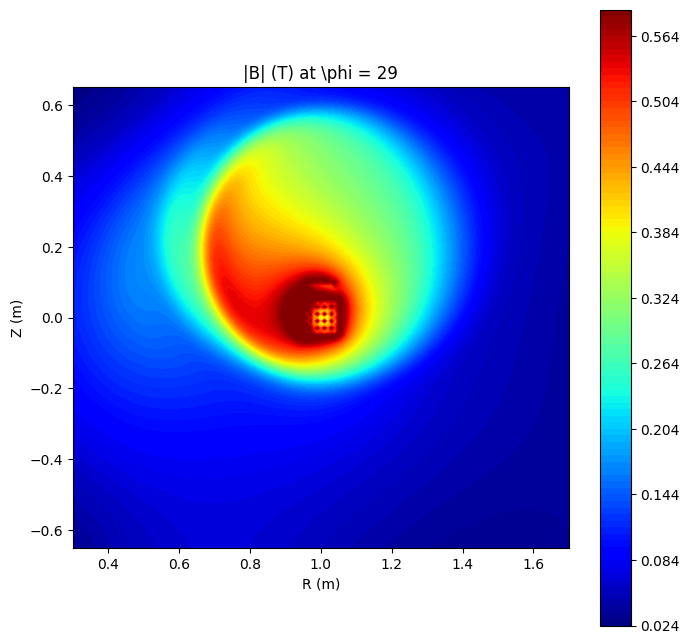

In [4]:
##############################################
# Plot the magnetic field
import matplotlib.pyplot as plt
R_center = 1.25
Z_center = 0.0

phi_angle = 30
phi_index = int(np.deg2rad(phi_angle)/delta_phi)
B_plotted = B[phi_index, :, :] # B Could be replaced by Bp, Br, Bz
B_plotted = np.transpose(B_plotted)
vmin, vmax = np.percentile(B_plotted, [0, 99])
B_plotted_clipped = np.clip(B_plotted, vmin, vmax)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect('equal')
ax.set_xlim(r_min, r_max)
ax.set_ylim(z_min, z_max)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')
ax.set_title('|B| (T) at \phi = {:.0f}'.format(np.rad2deg(phi_range[phi_index])))
# ax.contour(r_grid * grid_unit, z_grid * grid_unit, B_plotted, 100, cmap='jet')
# colorbar
B_contourf = plt.colorbar(ax.contourf(r_grid * grid_unit, z_grid * grid_unit, B_plotted_clipped, 100, cmap='jet'))
# plot the plasma center
if phi_angle == 0:
    ax.plot(R_center, Z_center, 'ro')
plt.show()